In [78]:
import logging
import random
import argparse
import os
import sys
import copy
import pygame
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
from pathlib import Path

from tqdm.autonotebook import tqdm

In [79]:
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)

In [90]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 1e-3
STEP_SIZE_ACTOR = 1e-4
STEP_SIZE_CRITIC = 1e-3
WEIGHT_DECAY = 0.
UPDATE_Q_NETWORK_EVERY_STEPS = 1

LOG_EVERY_STEPS = 100
PATH_SAVE_DIR = "./checkpoints/ddpg"

MAX_AVG_REWARD = 0.

NUM_EPISODES=1000
MAX_STEPS_EP=200
EPS_START=0.9
EPS_END=0.05
EPS_DECAY=0.995
SEED=1278173123

SAVE_EVERY_NTH=100

NUM_EPISODES_TEST = 1000

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PLOT = True

In [91]:
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [92]:
def plot_scores(scores, scores_avg, show=False, fname=None):
    """Plot scores over last 100 episodes."""
    fig = plt.figure()
    fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores, c="#6200ee", alpha=0.7)
    plt.plot(scores_avg, c="#03dac6")
    plt.ylabel("Score")
    plt.xlabel("Episodes")

    if fname:
        plt.savefig(fname)

    if show:
        plt.show()

    plt.close()


def save_checkpoint(state, filename):
    """Save state to filename."""
    torch.save(state, filename)

In [93]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[1]
    lim = 1.0 / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(num_features=fc1_units)

        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.bn2 = nn.BatchNorm1d(num_features=fc2_units)

        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    
    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = self.bn1(F.relu(self.fc1(state)))
        x = self.bn2(F.relu(self.fc2(x)))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(num_features=fc1_units)

        self.fc2 = nn.Linear(fc1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        x = self.bn1(F.leaky_relu(self.fc1(state)))
        x = torch.cat((x, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)


In [94]:
class DDPGAgent:
    """Interacts with and learns from the environment."""

    def __init__(
        self,
        state_size,
        action_size,
        buffer_size=int(1e5),
        batch_size=128,
        gamma=0.99,
        tau=1e-3,
        step_size_actor=1e-4,
        step_size_critic=1e-3,
        weight_decay=0,
        random_seed=2,
        device="cpu",
    ):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.device = device

        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=step_size_actor)

        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(
            self.critic_local.parameters(),
            lr=step_size_critic,
            weight_decay=weight_decay,
        )

        self.noise = OUNoise(action_size, random_seed)

        self.memory = ReplayBuffer(
            action_size=action_size,
            buffer_size=buffer_size,
            batch_size=batch_size,
            seed=random_seed,
            device=device,
        )

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences, self.gamma)

    def act(self, state, add_noise=True):
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.critic_local, self.critic_target, self.tau)
        self.soft_update(self.actor_local, self.actor_target, self.tau)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(
            target_model.parameters(), local_model.parameters()
        ):
            target_param.data.copy_(
                tau * local_param.data + (1.0 - tau) * target_param.data
            )


class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0.0, theta=0.15, sigma=0.2):
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(
            self.size
        )
        self.state = x + dx
        return self.state


class ReplayBuffer:

    experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def __init__(self, action_size, buffer_size, batch_size, seed, device="cpu"):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.device = device

    def add(self, state, action, reward, next_state, done):
        e = ReplayBuffer.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = (
            torch.from_numpy(np.vstack([e.state for e in experiences if e is not None]))
            .float()
            .to(self.device)
        )
        actions = (
            torch.from_numpy(
                np.vstack([e.action for e in experiences if e is not None])
            )
            .float()
            .to(self.device)
        )
        rewards = (
            torch.from_numpy(
                np.vstack([e.reward for e in experiences if e is not None])
            )
            .float()
            .to(self.device)
        )
        next_states = (
            torch.from_numpy(
                np.vstack([e.next_state for e in experiences if e is not None])
            )
            .float()
            .to(self.device)
        )
        dones = (
            torch.from_numpy(
                np.vstack([e.done for e in experiences if e is not None]).astype(
                    np.uint8
                )
            )
            .float()
            .to(self.device)
        )

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [95]:
def train(
    num_episodes,
    max_steps_ep,
    seed,
    save_every_nth,
    log_every_nth,
    filepath_checkpoint,
    buffer_size,
    batch_size,
    gamma,
    tau,
    stepsize_actor,
    stepsize_critic,
    weight_decay,
    logger,
    device,
    plot=False,
):
    logger.info("### Initializing environment...")
    env = gym.make("Pendulum-v1")
    ob, _ = env.reset(seed=seed)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.shape[0]
    agent = DDPGAgent(
        state_size=state_size,
        action_size=action_size,
        buffer_size=buffer_size,
        batch_size=batch_size,
        gamma=gamma,
        tau=tau,
        step_size_actor=stepsize_actor,
        step_size_critic=stepsize_critic,
        weight_decay=weight_decay,
        random_seed=seed,
        device=device,
    )
    
    Path(filepath_checkpoint).mkdir(parents=True, exist_ok=True)

    logger.info("### Training...")

    scores_deque = deque(maxlen=100)
    scores = []
    scores_avg = []
    for i_episode in tqdm(range(1, num_episodes + 1), desc="Episodes: ", position=0):
        ob, _ = env.reset()
        agent.reset()
        score = 0
        for _ in range(max_steps_ep):
            inputs = torch.from_numpy(ob).float().unsqueeze(0).to(device)
            action = agent.act(inputs)
            action = action[0]
            next_ob, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.step(ob, action, reward, next_ob, done)
            ob = next_ob
            score += reward

            if done:
                break

        scores_deque.append(score)
        scores.append(score)
        avg_reward = np.mean(scores_deque)
        scores_avg.append(avg_reward)

        if i_episode % log_every_nth == 0:
            logger.info(
                "Episode {}\tAverage Score: {:.2f}".format(
                    i_episode, avg_reward
                )
            )

        if i_episode % save_every_nth == 0:
            save_checkpoint(
                state={
                    "episode": i_episode,
                    "actor_state_dict": agent.actor_local.state_dict(),
                    "critic_state_dict": agent.critic_local.state_dict(),
                    "scores": scores,
                },
                filename=f"{filepath_checkpoint}/checkpoint.pth",
            )
            if plot:
                plot_scores(
                    scores=scores,
                    scores_avg=scores_avg,
                    fname=f"{filepath_checkpoint}/avg_scores.png",
                )
    return scores, scores_avg

scores, scores_avg = train(
    num_episodes=NUM_EPISODES,
    max_steps_ep=MAX_STEPS_EP,
    seed=SEED,
    save_every_nth=SAVE_EVERY_NTH,
    log_every_nth=LOG_EVERY_STEPS,
    filepath_checkpoint=PATH_SAVE_DIR,
    buffer_size=BUFFER_SIZE,
    batch_size=BATCH_SIZE,
    gamma=GAMMA,
    tau=TAU,
    stepsize_actor=STEP_SIZE_ACTOR,
    stepsize_critic=STEP_SIZE_CRITIC,
    weight_decay=WEIGHT_DECAY,
    logger=logger,
    device=DEVICE,
    plot=PLOT,
)

2023-12-26 09:42:57 - INFO - ### Initializing environment...
2023-12-26 09:42:57 - INFO - ### Training...


Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-12-26 09:49:43 - INFO - Episode 100	Average Score: -1121.09
2023-12-26 09:54:05 - INFO - Episode 200	Average Score: -429.88
2023-12-26 09:59:26 - INFO - Episode 300	Average Score: -325.53
2023-12-26 10:03:26 - INFO - Episode 400	Average Score: -409.73
2023-12-26 10:07:39 - INFO - Episode 500	Average Score: -460.16
2023-12-26 10:11:34 - INFO - Episode 600	Average Score: -535.75
2023-12-26 10:15:37 - INFO - Episode 700	Average Score: -512.84
2023-12-26 10:20:04 - INFO - Episode 800	Average Score: -543.53
2023-12-26 10:24:02 - INFO - Episode 900	Average Score: -600.30
2023-12-26 10:28:02 - INFO - Episode 1000	Average Score: -564.10


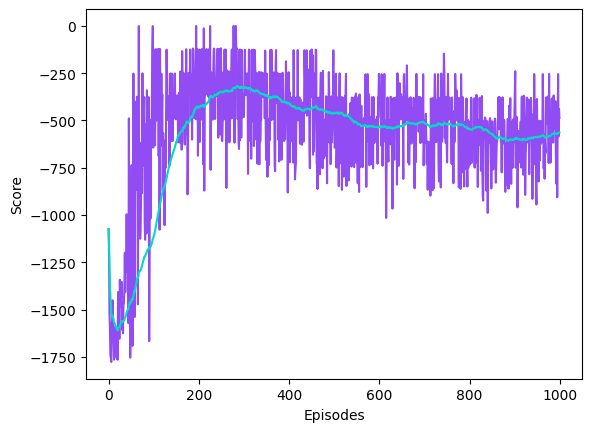

In [97]:
plot_scores(scores, scores_avg, show=True)

In [89]:
def test(seed, device, path, render):
    env = gym.make("Pendulum-v1", render_mode="human" if render else None)
    agent = DDPGAgent(
        state_size=env.observation_space.shape[0],
        action_size=env.action_space.shape[0],
        random_seed=seed,
    )

    if device == "cuda":
        checkpoint = torch.load(path)
    else:
        checkpoint = torch.load(path, map_location=lambda storage, loc: storage)
        
    agent.actor_local.load_state_dict(checkpoint.get("actor_state_dict"))
    agent.critic_local.load_state_dict(checkpoint.get("critic_state_dict"))

    ob, _ = env.reset(seed=seed)
    agent.reset()
    while True:
        inputs = torch.from_numpy(ob).float().unsqueeze(0).to(device)
        action = agent.act(inputs)
        action = action[0]
        env.render()
        next_ob, _, terminate, truncate, _ = env.step(action)
        ob = next_ob
        done = terminate | truncate
        if done:
            break
    env.close()

test(
    seed=SEED,
    device=DEVICE,
    path=f"{PATH_SAVE_DIR}/checkpoint.pth",
    render=None,
)

/Users/saipiens/src/repos/github/deep-rl-algos-methods/venv/lib/python3.10/site-packages/gymnasium/envs/classic_control/pendulum.py:173: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("Pendulum-v1", render_mode="rgb_array")
  gym.logger.warn(
